# llc4320 drifters: sandbox

- interpolate extra variables on trajectorie
- bin per ocean

In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14)
    w = cluster.scale(jobs=4)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.20:57721 Dashboard: http://10.148.0.20:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## oceans

In [2]:
import geopandas as gpd

In [11]:
osi = ut.osi

path = os.path.join(osi, "equinox/misc/World_Seas_IHO_v3/World_Seas_IHO_v3.shp")
path

'/home/datawork-lops-osi/equinox/misc/World_Seas_IHO_v3/World_Seas_IHO_v3.shp'

In [68]:
gdf = gpd.read_file(path)
gdf = gdf.rename(columns={c: c.lower() for c in gdf.columns})
gdf.head()

,name,id,longitude,latitude,min_x,min_y,max_x,max_y,area,mrgid,geometry
0,Rio de La Plata,33,-56.842478,-35.113338,-59.765656,-36.358856,-54.943024,-31.523437,31797,4325,"POLYGON ((-54.94302 -34.94791, -54.97875 -34.9..."
1,Bass Strait,62A,146.424291,-39.450520,143.532508,-41.440274,149.909468,-37.460793,112699,4366,"POLYGON ((149.90464 -37.54325, 149.90500 -37.5..."
2,Great Australian Bight,62,132.716558,-36.725916,117.614198,-43.566016,146.231156,-31.463669,1326209,4276,"POLYGON ((143.53251 -38.85535, 143.54856 -38.8..."
3,Tasman Sea,63,160.710798,-39.701056,146.872615,-50.866916,175.286985,-30.000000,3344624,4365,"POLYGON ((159.03333 -30.00000, 159.03983 -30.0..."
4,Mozambique Channel,45A,40.877244,-19.304095,32.430623,-26.842402,49.241982,-10.498872,1394283,4261,"POLYGON ((43.38218 -11.37021, 43.42691 -11.374..."


In [82]:
out = (1,)

In [84]:
out+= (2,)

In [85]:
out

(1, 2)

101 7 57 37
101 101


,name,id,longitude,latitude,min_x,min_y,max_x,max_y,area,mrgid,geometry
61,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-6.000000e+01,20.009049,0.075106,40501812,1914,"POLYGON ((8.974 -0.936, 8.975 -0.936, 8.975 -0..."
62,Southern Ocean,67,-26.632858,-68.039819,-180.000000,-8.556250e+01,180.000000,-60.000000,21695157,1907,"POLYGON ((180.000 -60.000, 180.000 -60.045, 18..."
63,South Pacific Ocean,61,-82.454779,-30.457193,-146.487909,-6.000000e+01,130.111292,3.391144,76681173,1910,"MULTIPOLYGON (((167.583 -22.733, 167.583 -22.7..."
68,Indian Ocean,45,79.208586,-32.724584,20.002616,-6.000000e+01,146.898219,10.444999,58230954,1904,"POLYGON ((51.415 10.445, 51.495 10.404, 51.575..."
72,North Pacific Ocean,57,-40.157441,23.962394,-76.985440,2.000000e-11,128.686531,58.211545,65154681,1908,"MULTIPOLYGON (((163.019 56.537, 163.022 56.533..."
75,North Atlantic Ocean,23,-37.624244,29.480034,-83.014914,-2.562642e-03,6.619967,68.638716,34507128,1912,"POLYGON ((-6.264 62.346, -6.177 62.324, -6.090..."
83,Arctic Ocean,17,-5.202583,84.864886,-180.000000,7.138751e+01,180.000000,90.000000,5120993,1906,"POLYGON ((180.000 90.000, 180.000 89.910, 180...."


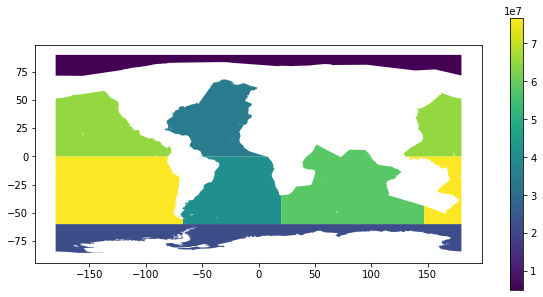

In [79]:
oceans = gdf.loc[gdf.name.str.contains('Ocean')]
seas = gdf.loc[gdf.name.str.contains('Sea')]
other = gdf.loc[~gdf.name.str.contains('Ocean|Sea')]

print(len(gdf), len(oceans), len(seas), len(other))
print(len(gdf), len(oceans)+len(seas)+len(other))

oceans.plot(column='area', figsize=(10,5), legend=True)

oceans

<AxesSubplot:>

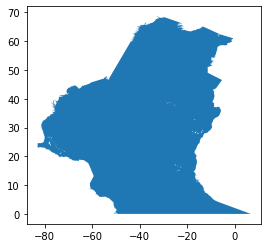

In [80]:
oceans.loc[oceans.name == 'North Atlantic Ocean'].plot()

In [2]:
# in library
oceans = ut.load_oceans()
oceans

,name,id,longitude,latitude,min_x,min_y,max_x,max_y,area,mrgid,geometry
61,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-6.000000e+01,20.009049,0.075106,40501812,1914,"POLYGON ((8.974 -0.936, 8.975 -0.936, 8.975 -0..."
62,Southern Ocean,67,-26.632858,-68.039819,-180.000000,-8.556250e+01,180.000000,-60.000000,21695157,1907,"POLYGON ((180.000 -60.000, 180.000 -60.045, 18..."
63,South Pacific Ocean,61,-82.454779,-30.457193,-146.487909,-6.000000e+01,130.111292,3.391144,76681173,1910,"MULTIPOLYGON (((167.583 -22.733, 167.583 -22.7..."
68,Indian Ocean,45,79.208586,-32.724584,20.002616,-6.000000e+01,146.898219,10.444999,58230954,1904,"POLYGON ((51.415 10.445, 51.495 10.404, 51.575..."
72,North Pacific Ocean,57,-40.157441,23.962394,-76.985440,2.000000e-11,128.686531,58.211545,65154681,1908,"MULTIPOLYGON (((163.019 56.537, 163.022 56.533..."
75,North Atlantic Ocean,23,-37.624244,29.480034,-83.014914,-2.562642e-03,6.619967,68.638716,34507128,1912,"POLYGON ((-6.264 62.346, -6.177 62.324, -6.090..."
83,Arctic Ocean,17,-5.202583,84.864886,-180.000000,7.138751e+01,180.000000,90.000000,5120993,1906,"POLYGON ((180.000 90.000, 180.000 89.910, 180...."


<AxesSubplot:>

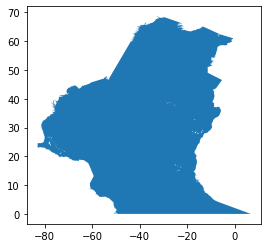

In [3]:
oceans.loc[oceans.name == 'North Atlantic Ocean'].plot()

---
## load data: trajectories + llc

In [ ]:
# load llc data
ds = ut.load_data(V=['SST', 'SSU', 'SSV'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])
ds

In [4]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
df = p.df['trajectory']

In [5]:
# add time in seconds
df = df.rename(columns={'time': 'date'})
t_start = df.date.min().compute()
df['time'] = (df['date'] - t_start)/pd.Timedelta('1D')

# Should check time sampling

df = df.persist()
# 5GB on disk, 25GB in memory

df.head()

,date,lat,lon,z,time
trajectory,,,,,
4000000.0,2011-11-15,41.797028,-34.864582,0.0,0.0
4000001.0,2011-11-15,42.514122,-34.864582,0.0,0.0
4000002.0,2011-11-15,43.223770,-34.864582,0.0,0.0
4000003.0,2011-11-15,43.925968,-34.864582,0.0,0.0
4000004.0,2011-11-15,44.620720,-34.864582,0.0,0.0


---

## start processing

In [7]:
def process_window(lon, lat, N, dt, **kwargs):
    ''' Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        lon,lat: pd.Series
            Longitude index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    if lon is None:
        uv = None
    else:
        # compute displacements
        lon1, lat1 = lon.shift(periods=-1), lat.shift(periods=-1)
        u = dr.haversine(lon, lat, lon1, lat)*1e3 *np.sign(lon1-lon) /dt/86400
        v = dr.haversine(lon, lat, lon, lat1)*1e3 *np.sign(lat1-lat) /dt/86400
        u = pd.Series(u, index=lon.index).fillna(method='ffill')
        v = pd.Series(v, index=lon.index).fillna(method='ffill')
        uv = (u + 1j*v)
    return dr.get_spectrum(uv, N, dt=dt, **kwargs)

**Cell below is the computationnally intensive part**

Peaks at 220GB of RAM

In [8]:
T = 60 # days
dt=1/24 # sampling
N = int(T/dt)+1 # output size

df_chunked = (df.reset_index() # don't understand why reset_index is required here
              .groupby('trajectory')
              .apply(dr.time_window_processing,
                     process_window,
                     ['lon', 'lat'],
                     T, 
                     N,
                     id_label='trajectory',
                     dt=1/24.,
                    )
              .persist()
             )

<ipython-input-8-6815c0d928ca>:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = (df.reset_index() # don't understand why reset_index is required here


In [9]:
# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
df_chunked = df_chunked.drop(columns='id')
df_chunked.head()

,time,lon,lat,0.0,0.016655100624566273,0.033310201249132546,0.04996530187369882,0.06662040249826509,0.08327550312283136,0.09993060374739764,...,-0.1665510062456627,-0.14989590562109645,-0.13324080499653018,-0.11658570437196392,-0.09993060374739764,-0.08327550312283136,-0.06662040249826509,-0.04996530187369882,-0.033310201249132546,-0.016655100624566273
trajectory,,,,,,,,,,,,,,,,,,,,,
1000038.0,30.0,-33.676429,-52.594186,0.524538,0.133783,0.111791,0.146400,0.011278,0.165607,0.058685,...,0.018281,0.029967,0.026024,0.083875,0.042077,0.091839,0.063079,0.045470,0.088119,0.339132
1000038.0,60.0,-29.237674,-50.967788,1.198771,0.324185,0.253451,0.290681,0.034363,0.066021,0.170910,...,0.051048,0.030542,0.003306,0.126455,0.255409,0.046729,0.063594,0.071592,0.159472,0.632436
1000038.0,90.0,-24.902603,-49.557339,0.364368,0.615906,0.426947,0.081047,0.001642,0.041771,0.066816,...,0.002386,0.019610,0.094394,0.004832,0.225937,0.197885,0.091288,0.035753,0.248429,0.036457
1000038.0,120.0,-22.193679,-49.064318,0.190423,0.384258,0.273943,0.101859,0.110949,0.041574,0.031536,...,0.011904,0.041910,0.119263,0.080170,0.018886,0.008113,0.042596,0.020105,0.172400,0.034812
1000038.0,150.0,-17.620525,-49.277763,1.581558,0.534713,0.484444,0.658229,0.156415,0.017785,0.014681,...,0.041796,0.079898,0.102977,0.060744,0.041873,0.340209,0.936775,0.511765,0.009427,0.913730


In [10]:
# store to parquet
df_chunked.columns = df_chunked.columns.astype(str) # fastparquet does not allow float column names
p.store_diagnostic('spectra_raw', df_chunked, overwrite=True)

No reindexing
deleting existing archive: /home1/datawork/aponte/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_raw
create new archive: /home1/datawork/aponte/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_raw


**Could move to another notebook from here**

In [5]:
# read parquet file
df_chunked = p.load_diagnostic('spectra_raw')

In [6]:
df_chunked = df_chunked.persist()
df_chunked.head()

,time,lon,lat,0.0,0.016655100624566273,0.033310201249132546,0.04996530187369882,0.06662040249826509,0.08327550312283136,0.09993060374739764,...,-0.1665510062456627,-0.14989590562109645,-0.13324080499653018,-0.11658570437196392,-0.09993060374739764,-0.08327550312283136,-0.06662040249826509,-0.04996530187369882,-0.033310201249132546,-0.016655100624566273
trajectory,,,,,,,,,,,,,,,,,,,,,
1000038.0,30,-33.676429,-52.594186,3.915657e+09,9.986866e+08,8.345128e+08,1.092868e+09,8.419309e+07,1.236248e+09,4.380779e+08,...,1.364636e+08,2.237032e+08,1.942696e+08,6.261271e+08,3.141050e+08,6.855730e+08,4.708818e+08,3.394350e+08,6.578037e+08,2.531605e+09
1000038.0,60,-29.237674,-50.967788,8.948778e+09,2.420025e+09,1.892002e+09,2.169922e+09,2.565167e+08,4.928429e+08,1.275838e+09,...,3.810681e+08,2.279970e+08,2.467901e+07,9.439827e+08,1.906615e+09,3.488295e+08,4.747249e+08,5.344286e+08,1.190454e+09,4.721111e+09
1000038.0,90,-24.902603,-49.557339,2.719992e+09,4.597712e+09,3.187141e+09,6.050158e+08,1.225445e+07,3.118189e+08,4.987753e+08,...,1.780883e+07,1.463864e+08,7.046472e+08,3.607015e+07,1.686611e+09,1.477205e+09,6.814584e+08,2.668927e+08,1.854515e+09,2.721536e+08
1000038.0,120,-22.193679,-49.064318,1.421501e+09,2.868470e+09,2.044971e+09,7.603710e+08,8.282312e+08,3.103488e+08,2.354152e+08,...,8.886304e+07,3.128601e+08,8.902968e+08,5.984626e+08,1.409798e+08,6.056013e+07,3.179804e+08,1.500806e+08,1.286961e+09,2.598730e+08
1000038.0,150,-17.620525,-49.277763,1.180627e+10,3.991610e+09,3.616356e+09,4.913650e+09,1.167632e+09,1.327617e+08,1.095943e+08,...,3.120046e+08,5.964347e+08,7.687227e+08,4.534484e+08,3.125789e+08,2.539647e+09,6.992984e+09,3.820302e+09,7.037415e+07,6.820957e+09


In [11]:
# bin geographically
lat_bins = np.arange(-60, 60, 1.)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)

E = df_chunked.groupby(['lat_cut']).mean().compute()

#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(E.set_index(E.index.map(lambda v: v.mid))
              .drop(columns=['time','lon','lat'])
              .reset_index(), id_vars=['lat_cut',], var_name='frequency')
              .rename(columns={'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
ds['frequency'] = ds['frequency'].astype(float)
ds = ds.sortby('frequency')

# store diagnostic (not done here)
#p.store_diagnostic('spectra_lat', ds, overwrite=True)

# may be loaded with 
#ds = p.load_diagnostic('spectra_lat.zarr')

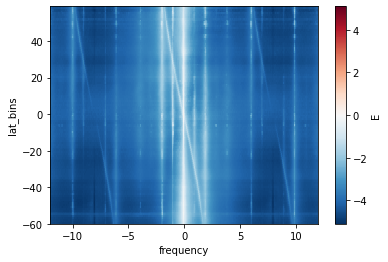

In [12]:
np.log10(ds.E).plot()

## Close cluster

In [13]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
